In [ ]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

import grand.dataio.root_trees as rt

import database.tools as tools

import importlib

#plt.style.use('seaborn-v0_8-colorblind')
plt.style.use('tableau-colorblind10')
plt.style.use('/pbs/home/p/pcorrea/tools/matplotlib_style_sans-serif.txt')

%matplotlib inline

tools.load_logger('debug')

Welcome to JupyROOT 6.30/04


<Logger database.v2.tools (DEBUG)>

In [134]:
RUN     = 145
MODE    = 'MD'
TH1     = 45
TH2     = 35
TQUIET  = 500
TPER    = 1000
TSEPMAX = 200
NCMIN   = 2#1
NCMAX   = 10#7

N_SAMPLES  = 1024
N_CHANNELS = 3

database_dir    = '/sps/grand/pcorrea/nutrig/database/v2/bkg'
database_subdir = os.path.join(database_dir,f'GP80_RUN_{RUN}_TH1_{TH1}_TH2_{TH2}_TQUIET_{TQUIET}_TPER_{TPER}_TSEPMAX_{TSEPMAX}_NCMIN_{NCMIN}_NCMAX_{NCMAX}')

path_metadata_file = os.path.join(database_subdir,'metadata.npz')

database_subdir_filtered = os.path.join(database_subdir,'filtered')
database_subdir_raw      = os.path.join(database_subdir,'raw')

paths_data_files_filtered = sorted( glob.glob( os.path.join(database_subdir_filtered,'*.npz') ) )
paths_data_files_raw      = sorted( glob.glob( os.path.join(database_subdir_raw,'*.npz') ) )

In [142]:
test_idx = 1
test_file_filtered = np.load(paths_data_files_filtered[test_idx])
test_file_raw = np.load(paths_data_files_raw[test_idx])

traces_filtered = test_file_filtered['traces']
FLT0_flags = test_file_filtered['FLT0_flags']
FLT0_first_T1_idcs = test_file_filtered['FLT0_first_T1_idcs']
traces_raw = test_file_raw['traces']

In [139]:
def shift_with_padding(trace, shift):
    trace_shifted = np.zeros_like(trace)
    if shift > 0:
        trace_shifted[shift:] = trace[:-shift]
    elif shift < 0:
        trace_shifted[:shift] = trace[-shift:]
    else:
        trace_shifted[:] = trace
    return trace_shifted


def shift_peak_position(traces,
                        FLT0_first_T1_idcs,
                        new_peak_position=225,
                        samples_from_edge=100):
    
    # Take the first triggered channel per event as the reference
    FLT0_T1_idcs_ref = np.min( np.where(FLT0_flags,FLT0_first_T1_idcs,int(1e9)),axis=1 )

    # Compute the shifts we need to perform
    shifts = new_peak_position - FLT0_T1_idcs_ref + samples_from_edge

    # Perform the shifts
    traces_shifted             = np.empty_like(traces)
    FLT0_first_T1_idcs_shifted = np.empty_like(FLT0_first_T1_idcs)

    for i in range(traces.shape[0]):
        for j in range(traces.shape[1]):
            #traces_shifted[i,j,:samples_from_edge] = traces_raw[i,j,:samples_from_edge]
            #traces_shifted[i,j,samples_from_edge:] = np.roll(traces_raw[i,j,samples_from_edge:],shifts[i])
            traces_shifted[i,j] = shift_with_padding(traces[i,j],shifts[i])

            FLT0_first_T1_idcs_shifted[i] = np.where(FLT0_flags[i],FLT0_first_T1_idcs[i] + shifts[i],FLT0_first_T1_idcs[i])

    return traces_shifted, FLT0_first_T1_idcs_shifted

In [140]:
from scipy.signal.windows import gaussian

fade = 100
std = fade/4
gauss = gaussian(fade*2,std)
gauss /= np.max(gauss) # normalize to 1

fade_in  = gauss[:fade]
fade_out = gauss[-fade:]

window = np.ones(N_SAMPLES)
window[:fade] = fade_in
window[-fade:] = fade_out

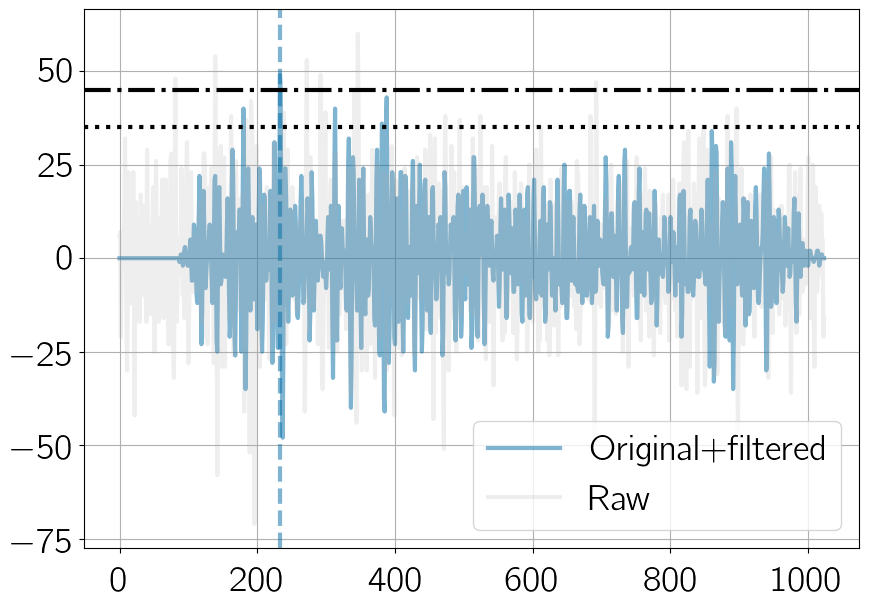

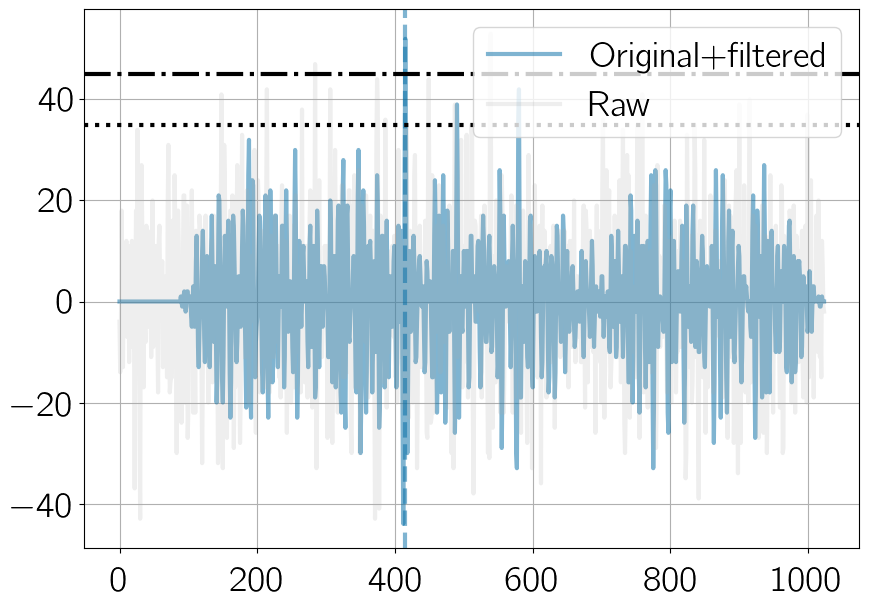

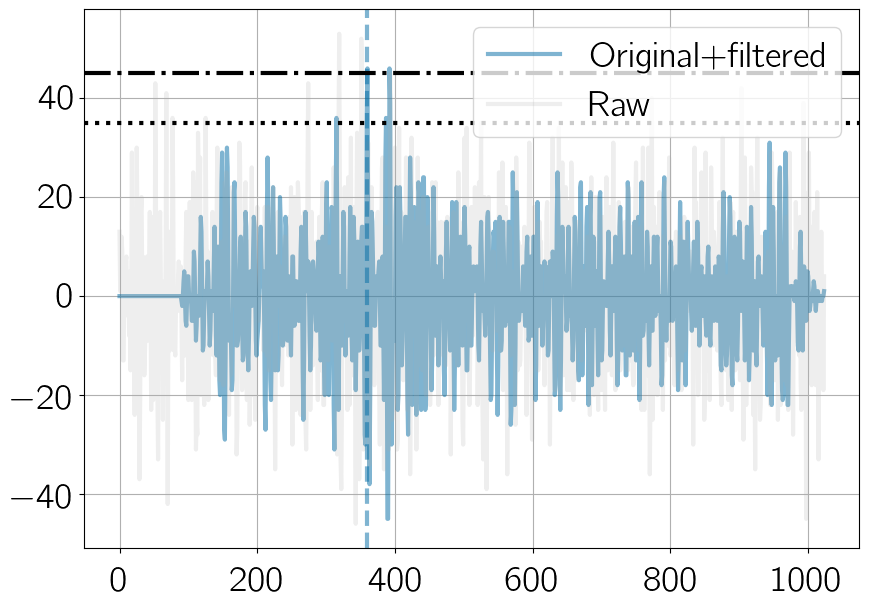

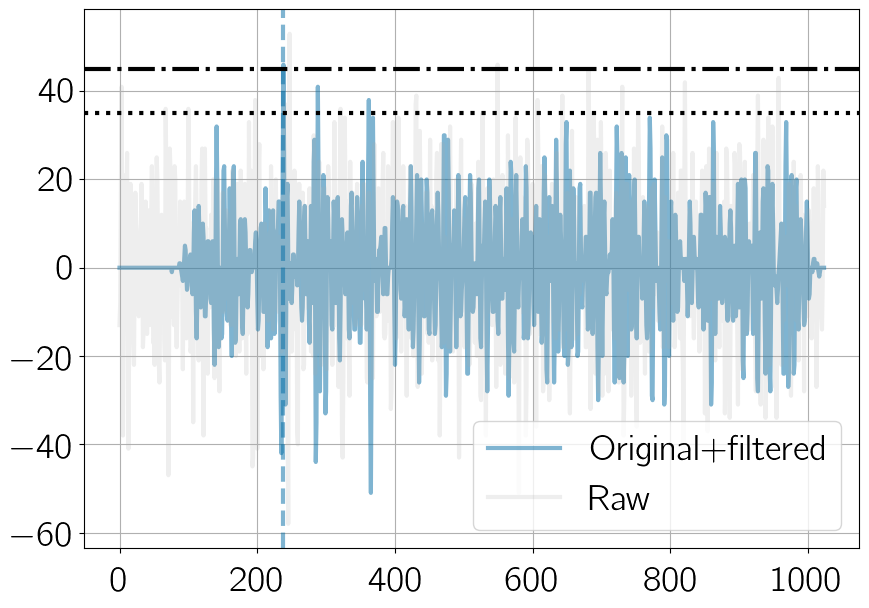

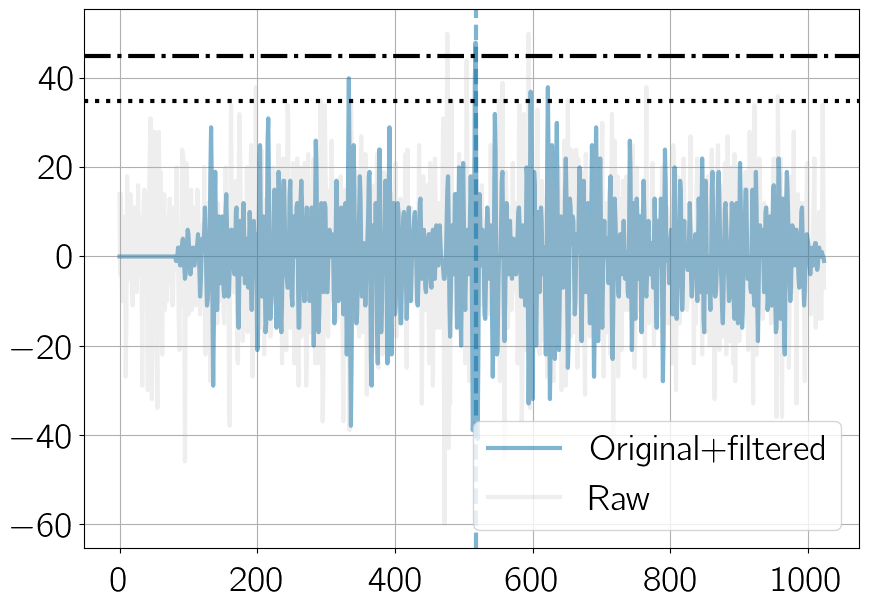

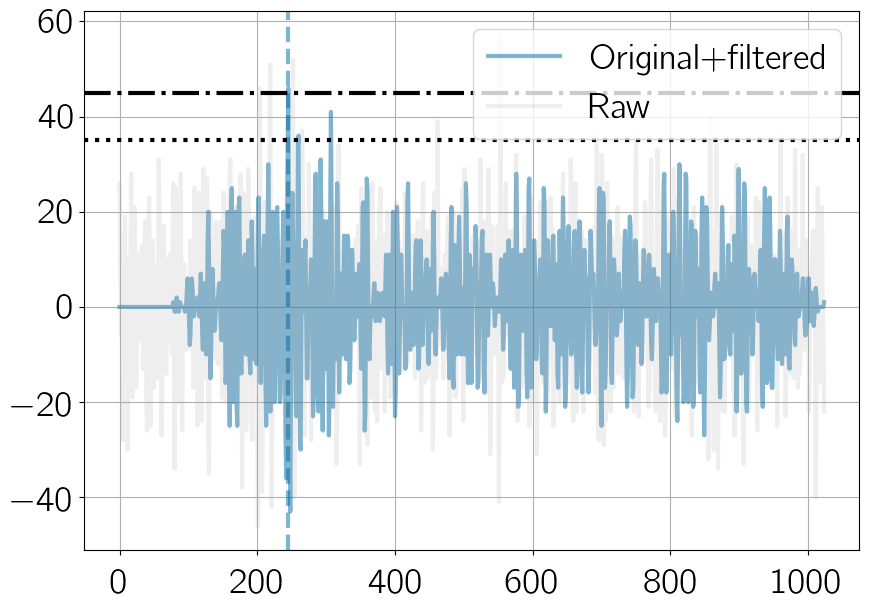

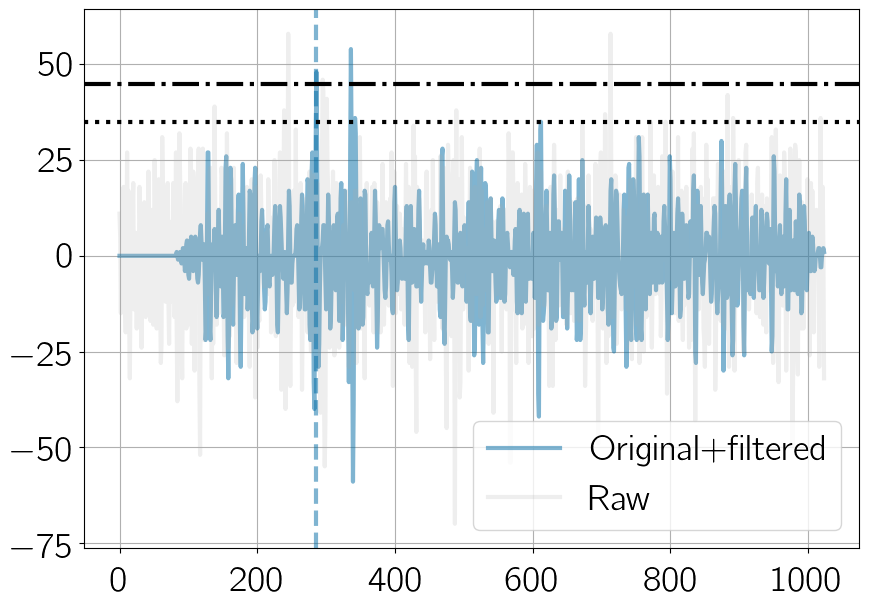

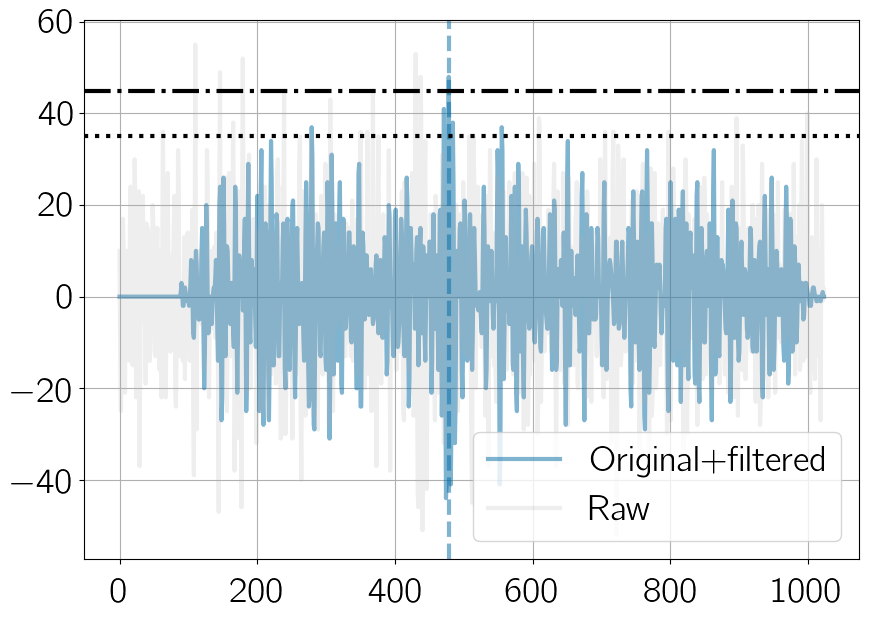

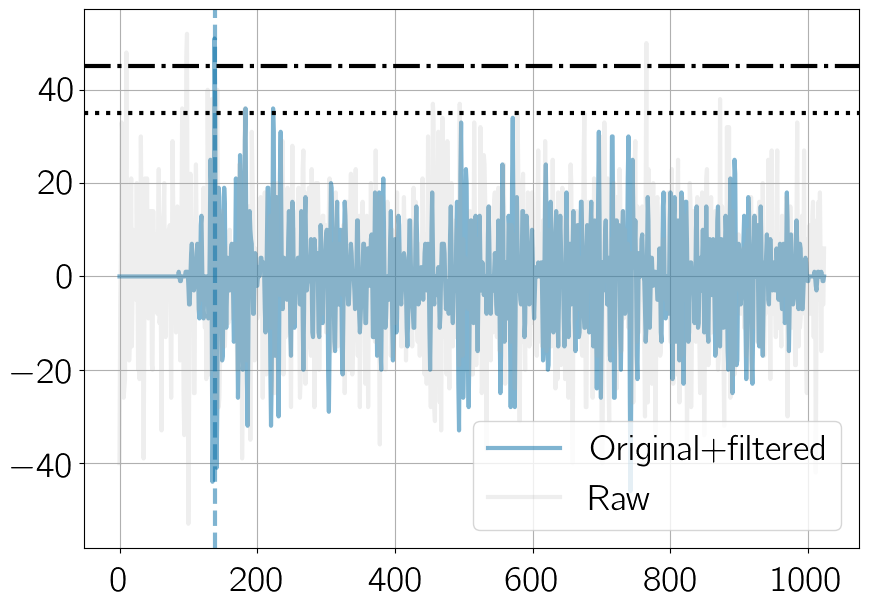

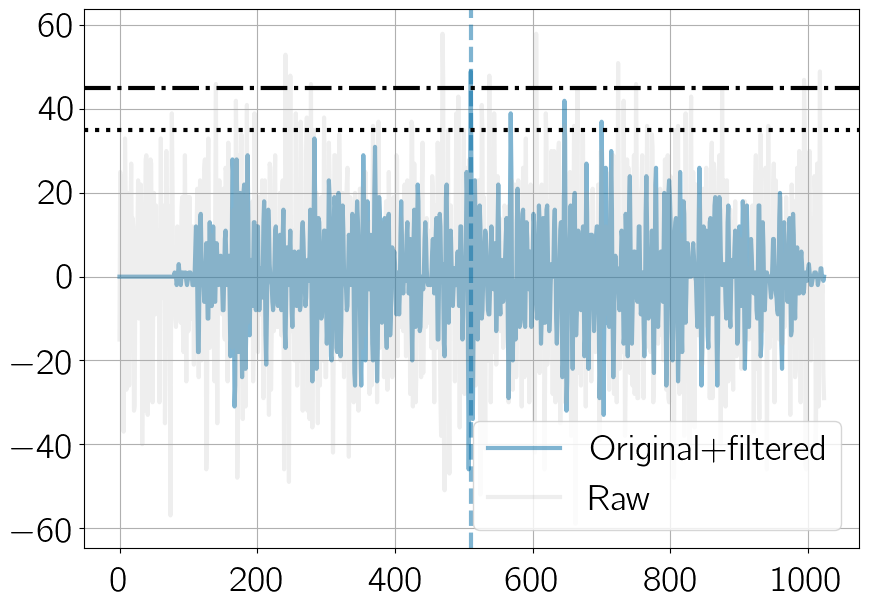

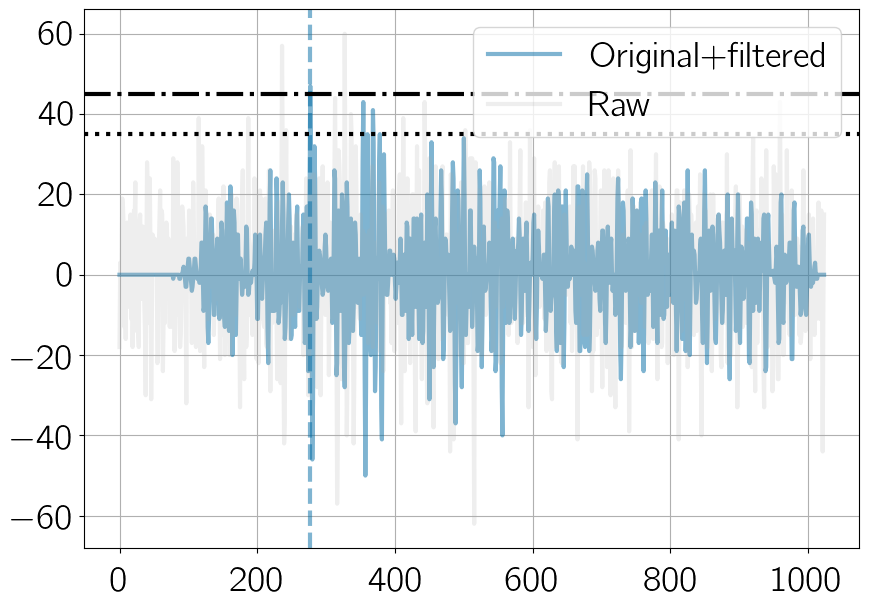

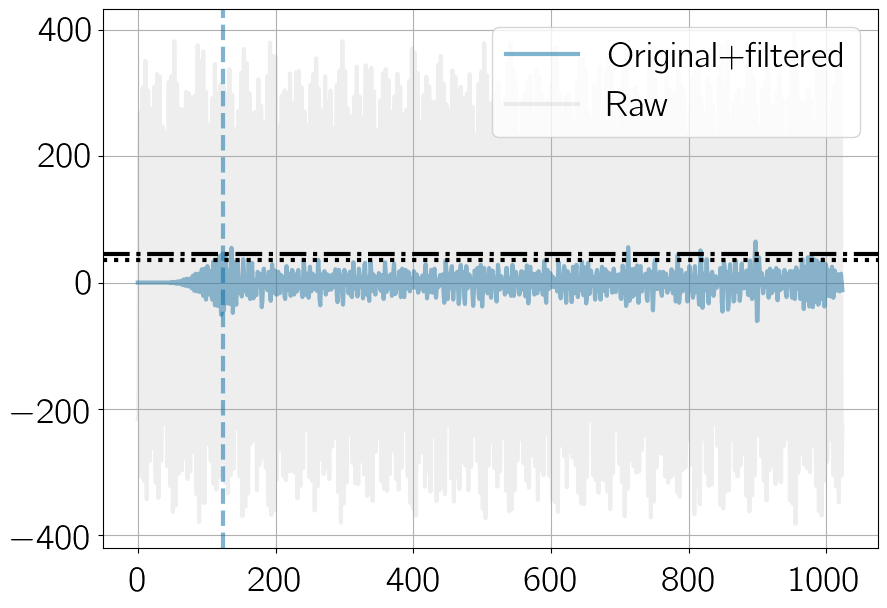

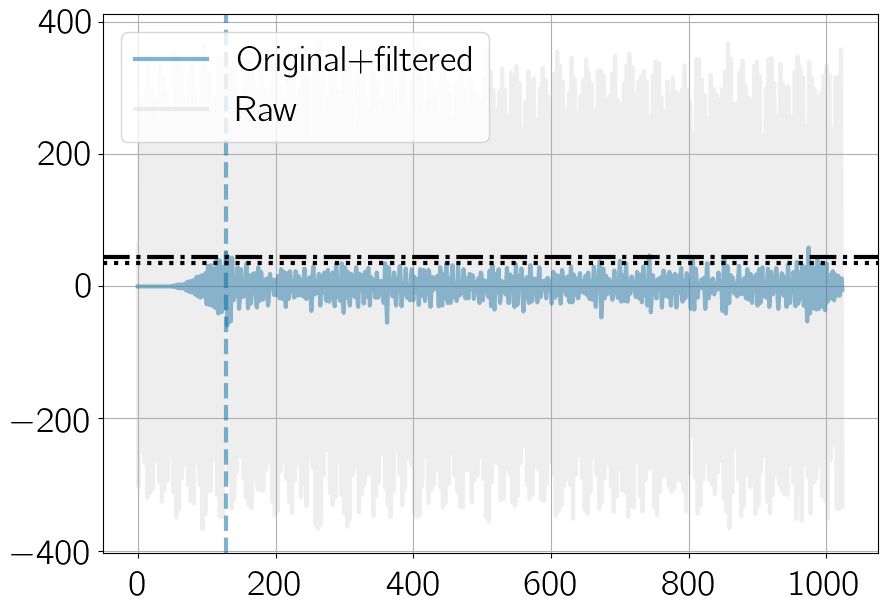

In [145]:
traces_shifted, FLT0_first_T1_idcs_shifted = shift_peak_position(traces_filtered*window,FLT0_first_T1_idcs)
traces_shifted_filtered = traces_shifted#tools.filter_traces_bandpass(traces_shifted)*window

plot_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pol = 1
for i in range(0,20):
    if FLT0_first_T1_idcs[i,pol] >= 0:
        plt.plot(traces_filtered[i,pol],color=plot_colors[0],alpha=.5,label='Original+filtered')
        #plt.plot(traces_shifted_filtered[i,pol],color=plot_colors[1],alpha=.5,label='Shifted+filtered')
        plt.plot(traces_raw[i,pol],color=plot_colors[2],alpha=.2,label='Raw')
        plt.axvline(FLT0_first_T1_idcs[i,pol],color=plot_colors[0],ls='--',alpha=.5)
        #plt.axvline(FLT0_first_T1_idcs_shifted[i,pol],color=plot_colors[1],ls='--',alpha=.5)
        plt.axhline(TH1,color='k',ls='-.')
        plt.axhline(TH2,color='k',ls=':')
        plt.legend(frameon=True)
        plt.show()

In [146]:
len( np.loadtxt('/sps/grand/pcorrea/nutrig/database/v2/lowpass115MHz.txt',delimiter=',') )

83

group delay is (83-1)/2 = 41 samples = 82 ns, with 83 the number of FIR coefficients